In [41]:
import pandas as pd 
import numpy as np
from numpy import array
import os
from pathlib import Path
from collections import namedtuple
import re
from sklearn.preprocessing import StandardScaler
import pickle
import random
from ipynb.fs.full.evaluation import *
from scipy.signal import butter, lfilter, freqz
from EEG_Toolbox import *

### Contents 

- Annotate the the datasets by using the timestamps
- Reject datasets that do not have annotations, less than 5 paragraphs or duplicate timestamp


### 1) Annotating and building the datasets

In [42]:
def extract_user_number(s):
    """
    Extracts the user number from a given path
    :s: path of the file
    """
    s = str(s).split("_")[0] # extract the user from the path
    s = s.split("/")[6] # split the path to isolate the user
    s = s.replace("User","") # remove the word "User"
    s = int(re.sub(r'[a-z]+', '', s, re.I)) # remove alphabetical characters
    return s 


In [43]:
def extract_test_number(s):
    """
    Extracts the test number from a given path
    :s: path of the file
    """
    s = s.split("/")[7]
    s = s.split("_")[1]
    s = int(re.sub(r'[a-z]+', '', s, re.I))
    return s 

In [44]:
p = Path("/cs/home/ybk1/Dissertation/Experiment Anonymised Version")
# p = Path("C://Users//User//OneDrive - University of St Andrews//Modules//CS5099//4. Data Documents//dataset//INSTRUMENTED DIGITAL AND PAPER READINGDATASET//Experiment Anonymised Version")

In [45]:
def get_all_datasets(p):
    """
    Loops through all the folders to find all the datasets and json files for training
    p: path of the root folder
    """
    File = namedtuple('File', 'name path size')
    files = []
    for item in p.glob('**/*'): # loops thorough all the files in all the sub-directories
        if item.match('*rawEEGData.csv')  and "baseline" not in item.name:
            name = item.name
            path = Path.resolve(item).parent
            size = item.stat().st_size

            files.append(File(name,path, size )) # stores the name, path and size in named tuple
    
    df = pd.DataFrame(files)
    df['user'] = df["path"].apply(extract_user_number)
    df.to_csv("All EEG files.csv", index=False)
    
    return df

In [46]:
def check_json(labels):
    """
    Method for checking the json to see how many paragraphs it contains
    and whether the timestamps are distinct
    :labels: annotations.json in a DataFrame
    """
    #check whether there are 5 paragraphs
    no_para = len(labels)
    are_timestamps_distinct = False
    if no_para == 0: # checks if the json is empty
        return no_para, are_timestamps_distinct
    else:
        if len(labels) != 5:
            print ("There are less than 5 paragraphs in the dataset")
        else:
            print("There are 5 paragraphs in the dataset")

        #check whether the timestamps are distincts
        cols = ["timeRangeStart", "timeRangeEnd"]
        for col in cols:
            array_length= len(array(labels[col]))
            set_length = len(set(array(labels[col])))
            if array_length == set_length:
                print(col + " has distinct values")
                are_timestamps_distinct = True
                break
            else: 
                print(col + " does not have distinct values")
                are_timestamps_distinct = False
                break

        print(are_timestamps_distinct)
        return no_para, are_timestamps_distinct 
    

In [47]:
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def filter_sample(data, lowcut=0.1, highcut=40.0, fs=500, order=4):
    """
    Method for filtering the dataframe by applying the bandpass filter
    :df: sample that includes channels, timestamps and labels
    :lowcut: low-pass threshold
    :highcut: high-pass threshold
    :order: order that meets the filtering criteria
    """
    filtered_data = np.zeros(data.shape)
    for channel in range(data.shape[1]):
            # print 'Filtering electrode %s...' % electrode
        filtered_data[:, channel] = butter_bandpass_filter(data[:, channel], lowcut, highcut, fs, order=order)
    return filtered_data
    

In [48]:
def label(timestamp, annotation, labels):
    """
    Method for adding the labels to the dataframe
    
    :return: relevant score of attention/interest/effort within the correct time range
    :timestamp: timestamp at the current iteration
    :annotation: annotation at the current interation
    :labels: annotations.json in array format
    """
    for row in labels:
        time_start = row[-2]
        time_end = row[-1]
        ann_dict = {"effort": row[-3], "attention": row[-4], "interest": row[-5],"para": row[-6]}
        if timestamp >= time_start and timestamp < time_end: # checks if the timestamp is witin the start and end range
            return ann_dict[annotation] # returns the relevant score stored in the dictionary
        

In [49]:
def add_labels(data, labels):
    """
    Method for processing the dataset by creating columns for effort, attention, interest and paragraph using the label function
    :data: EEG dataset
    :labels: annotations.json in array format
    """
    annotations = ["effort", "attention", "interest", "para"]
    for ann in annotations: # loops through the labels, and creates new columns based on the values within the timestamp range
        data[ann] = data["Timestamp"].apply(label, annotation=ann, labels=labels)
    
    initial_rows = len(data)
    data = data.dropna()
    final_rows = len(data)
    dropped_rows = initial_rows - final_rows
    print("Initial rows: {0}\nFinal rows: {1}\nDropped rows: {2}".format(initial_rows, 
                                                                         final_rows, 
                                                                         dropped_rows))
    return data , initial_rows, final_rows, dropped_rows

In [50]:
def export_datasets_to_csv(labeled_data, path):
    """
    Exports the labeled data as three separate csv files for interest, effort and attention
    :labeled_data: annotated datasets with columns for interest, effort and attention
    :path: path to save the dataset
    """
    X = labeled_data.iloc[:,:9] # inputs i.e channels and timestamp
    labels = ['interest', 'effort', 'attention']
    for label in labels:
        dataset = pd.concat([X, labeled_data[label]], axis=1).to_csv(path +  "/" +'EEG_' + label + '_dataset.csv', index=False)   


In [51]:
def build_all_datasets(df):
    """
    Method for building all the training sets by applying annotations at relevant timestamps
    and splitting the training sets into attention, interest and effort
    :df: DataFrame that includes all of the datasets i.e "All EEG Files.csv"
    :ds: dataset
    """
    ds = array(df)
    json = "annotations.json" # json file that contains the labels and annotations for the data
    File = namedtuple('File', 'path user test no_para are_timestamps_distinct initial_rows final_rows dropped_rows')
    files = []
    
    for row in ds:
        ds_path = str(row[1]) # Get the path of the dataset
        ds_csv = row[0] # get the name of the csv file
        print("Working on this csv: {}".format(ds_csv))
        ds_user = row[3] # get the user number
        ds_test = extract_test_number(ds_path)
        ds_data = pd.read_csv(ds_path + "/" + ds_csv)
        ds_labels = pd.read_json(ds_path + "/" + json)
        no_para, are_timestamps_distinct = check_json(ds_labels) # check the json file
                
        ds_labels = array(ds_labels)
        if are_timestamps_distinct == False:
            print("Don't process")
            initial_rows, final_rows  = len(ds_data), len(ds_data)
            dropped_rows = 0
            files.append(File(ds_path, ds_user, ds_test, no_para,are_timestamps_distinct,
                             initial_rows, final_rows, dropped_rows))          
        else:
            labeled_data, initial_rows, final_rows, dropped_rows = add_labels(ds_data, ds_labels) # Gets the labeled data
#             export_datasets_to_csv(labeled_data, ds_path) # Exports the 3 datasets to the appropriate path
            labeled_data.to_csv(ds_path + "/" + "annotated_EEG.csv", index=False)
            files.append(File(ds_path, ds_user, ds_test, no_para, are_timestamps_distinct,
                         initial_rows, final_rows, dropped_rows))
            
    training_files = pd.DataFrame(files)
    training_files.to_csv("Trainingfiles.csv", index=False)
    return training_files
        

In [52]:
def build_all_datasets_test():
    """
    Test method for building a single group of training sets by applying annotations at relevant timestamps
    and splitting the training sets into attention, interest and effort
    :df: DataFrame that includes all of the datasets
    :ds: dataset
    """
    # User001_test1_BET_01_30-08-2019_recording0_U1567156556_EYETRACKER_cleanFixationData.csv
    # /cs/home/ybk1/Dissertation/Experiment Anonymised Version/User001_Group_Test_30-08-2019--10-07-00/User001_test1_BET_01_30-08-2019/User001_test1_BET_01_30-08-2019_recording0
    ds_path = "/cs/home/ybk1/Dissertation/Experiment Anonymised Version/User001_Group_Test_30-08-2019--10-07-00/User001_test1_BET_01_30-08-2019/User001_test1_BET_01_30-08-2019_recording0"
    ds_csv = "User001_test1_BET_01_30-08-2019_recording0_U1567156556_EEG_rawEEGData.csv"
    json = "annotations.json"
    
    File = namedtuple('File', 'path user no_para are_timestamps_distinct initial_rows final_rows dropped_rows')
    files = []
        
    ds_user = 1 # get the user number
    ds_data = pd.read_csv(ds_path + "/" + ds_csv)
    ds_labels = pd.read_json(ds_path + "/" + json)
    no_para, are_timestamps_distinct = check_json(ds_labels) # check the json file


    ds_labels = array(ds_labels)
    if are_timestamps_distinct == False:
        print("Don't process")
        initial_rows, final_rows  = len(ds_data), len(ds_data)
        dropped_rows = 0
        files.append(File(ds_path, ds_user, no_para,are_timestamps_distinct,
                         initial_rows, final_rows, dropped_rows))
    else:
        labeled_data, initial_rows, final_rows, dropped_rows = add_labels(ds_data, ds_labels) # Gets the labeled data
#         export_datasets_to_csv(labeled_data, ds_path) # Exports the 3 datasets to the appropriate path
        labeled_data.to_csv(ds_path + "/" + "annotated_EEG.csv", index=False)
        files.append(File(ds_path, ds_user, no_para, are_timestamps_distinct,
                         initial_rows, final_rows, dropped_rows))
        
    training_files = pd.DataFrame(files)
    return training_files
        

**Run this block to rebuild the datasets**

In [53]:
# all_datasets = get_all_datasets(p)
# build_all_datasets(all_datasets)

In [54]:
# build_all_datasets_test()

### 2) Cleaning the dataset build: extract viable datasets from the training files 

- remove the files that have zero final rows
- remove files that have empty JSON's
- remove files that only have 4 paragraphs
- remove files with indistince timestamps

In [55]:
def clean_training_files():
    """
    Method for removing:
    - Files with zero final rows
    - remove files with empty Json's
    - Files with only 4 paragraphs
    - Files with indistinct timestamp
    """
    tf = pd.read_csv("Trainingfiles.csv")
    print("Initial length of training files: {}".format(len(tf)))
    
    zero_final = tf['final_rows'] == 0 # remove the files with zero final row
    empty_json = tf['no_para'] == 0 # remove files with empty JSON's
    four_para = tf['no_para'] == 4 # remove files with only four paragraphs
    indistinct_timestamp = tf['are_timestamps_distinct'] == False # remove files with indistinct timestamps
    files_rm = [zero_final, empty_json, four_para, indistinct_timestamp] # store them all in a list
    for file_rm in files_rm:
        tf = tf.drop(tf[file_rm].index) # drop files sequentially
    
    tf = tf[(tf['user'] != 21) & (tf['user'] != 16)] # remove users 16 and 21 as they only have 2 and 1 test respectively
    print("Final length of training files: {}".format(len(tf)))
    tf.to_csv("clean_trainingfiles.csv", index=False)
    return tf
    

### 3) Sampling the data 

In this part, the data will be sampled at 120 window size

In [56]:
def get_samples_from_test(df, slider, sample_size, bandpass):
    """
    Method for creating samples within a dataset
    :df: test that is being sampled
    :slider: the amount by which the window slides during sampling. The lower the number, the more samples.
    """
    df = df.drop(["Timestamp", " AdjustedUnix"], axis=1) #remove unnecessary columns
    Sample = namedtuple('Sample', 'inputs effort attention interest')
    sampled_tests = []
    
    
    # Group by paragraph and add each paragraph into an array
    paragraphs = df.groupby('para') 
    paragraphs = [paragraphs.get_group(x) for x in paragraphs.groups]
    
    incorrect_length = 0
    # Loop trough each paragraph to create samples
    for para in paragraphs:
        
        if not len(para) > sample_size: # check the length of paragraph if it is bigger than the sample size
            continue
            
        new_sample_length = len(para[0:sample_size])
        counter = 0
        while  new_sample_length >= sample_size: # this checks that the new sample is at least greater than or equal to sample size
            """
            **Sliding window algorithm**
            - Create new samples based on sample size and iterate using the slider size for size of overlap
            - Create separate values for inputs, effort, attention, interest to add to a tuple
            """
            new_sample = para[counter : counter + sample_size] #gets new sample based on the counter and sample size
            new_sample_length = len(new_sample)
            
            #checks new_sample length
            if new_sample_length == sample_size:
                # Extract the sample specific data and apply band pass filtering if true
                if bandpass == True:
#                     _, inputs = chebyBandpassFilter(array(new_sample.iloc[:, :8]), [0.05, 0.1, 40, 42])
                    inputs = filter_sample(array(new_sample.iloc[:, :8]))
                else:
                    inputs = array(new_sample.iloc[:, :8])
                
                effort, attention, interest = new_sample[["effort", "attention", "interest"]].T.values
                sampled_tests.append(Sample(inputs, int(max(effort)), int(max(attention)), int(max(interest))))
            else:
                incorrect_length += 1
                continue             
         
            # increase by slider
            counter += slider
        
        
    sampled_tests_df = pd.DataFrame(sampled_tests) #sampled list data frame
    print("This sampled test has {0} samples".format(len(sampled_tests_df)))
    inputs_and_labels = {}
    
    inputs_list = sampled_tests_df['inputs'].values
    inputs_list = np.rollaxis(np.dstack(inputs_list),-1) #combine all the inputs into 3D array
    inputs_and_labels['inputs'] = inputs_list # add inputs into dictionary
    labels = ["effort", "attention", "interest"]
    for label in labels: 
        inputs_and_labels[label] = array(sampled_tests_df[label].values) #add lables to dictionary
    

    print(inputs_and_labels['inputs'])
    return inputs_and_labels   
    

In [57]:
def generate_all_samples_or_tests(slider, sample_size, agg, bandpass):
    """
    Method for generating samples for all the tests with a default sample size of 60 and slide of 60. 
    Combines all tests of a user into a tuple consisting of inputs, attention, interest, effort. 
    Saves all tests in a dictionary
    :slider:
    :sample_size:
    """
    clean_tf = pd.read_csv("clean_trainingfiles.csv")
    users = set(clean_tf['user'])
    user_tests = {}
    
 
    for user in users:
        
        #store all of user's test in a dictionary
        user_test_paths = array(clean_tf[clean_tf['user'] == user]["path"])
    

        file = "annotated_EEG.csv"

        # Loop through all the tests, generate samples and then append them to an array in the dictionary
        inputs_and_labels = {"inputs":[], "attention":[], "effort":[], "interest":[]}
        for test_path in user_test_paths:
            print("Processing user {0} , test {1}".format(extract_user_number(test_path), extract_test_number(test_path)))
            test_file = test_path + "/" + file
            test_dataset = pd.read_csv(test_file)
            if len(test_dataset) == 0:
                continue
        #convert the test into windowed format with samples     
            sampled_test_dataset = get_samples_from_test(test_dataset, slider, sample_size, bandpass)
        #add all the tests to the dictionary, inputs and labels
            for key in inputs_and_labels:
                inputs_and_labels[key].append(sampled_test_dataset[key])
                
        if agg == True: 
            # loop through he dictionary and concatenate the list
            for key in inputs_and_labels:
                inputs_and_labels[key] = np.concatenate(inputs_and_labels[key], axis=0)
                print("Shape of {0}: {1}".format(key,inputs_and_labels[key].shape ))
        
        user_tests[user] = inputs_and_labels
        print(user_tests.keys())

 
    print("Adding dictionary...")
    return user_tests

### 4) Save datasets


In [63]:
def save_datasets(window_size, slider, bandpass):
    all_tests_agg = generate_all_samples_or_tests(slider,window_size,agg=True, bandpass=bandpass)
    all_tests_no_agg = generate_all_samples_or_tests(slider,window_size,agg=False, bandpass=bandpass)
    saved_file_agg = "/cs/home/ybk1/Dissertation/data/saved user and test data/all_users_sampled_{0}_window_annotated_EEG_agg_bandpass_{1}_slider_{2}.pickle".format(window_size,bandpass, slider)
    saved_file_no_agg = "/cs/home/ybk1/Dissertation/data/saved user and test data/all_users_sampled_{0}_window_annotated_EEG_no_agg_bandpass_{1}_slider_{2}.pickle".format(window_size,bandpass, slider)
    save_file(saved_file_agg, all_tests_agg)
    save_file(saved_file_no_agg, all_tests_no_agg)



In [59]:
def combine_test_per_user(agg=False):
    """
    Combines all tests per user without sampling
    """
    df = pd.read_csv("clean_trainingfiles.csv")
    users = set(array(df['user']))
    all_users = {}
    
    file = "annotated_EEG.csv"
    for user in users:
        test_paths = array(df[df['user'] == user]["path"])
        test_list = []
        for test_path in test_paths:
            test_file = test_path + "/" + file
            test_dataset = pd.read_csv(test_file)
            test_list.append(test_dataset)
            
        if agg == True: test_list  = pd.concat(test_list)
            
        all_users[user] = test_list
        print("Processed user {0}:\tDataframe size: {1}".format(user, len(test_list)))
        
    print("Saving dictionary...")
    saved_file = "/cs/home/ybk1/Dissertation/data/all_tests_EEG_{0}.pickle".format(agg)
    with open(saved_file, 'wb') as handle:            
        pickle.dump(all_users, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return all_users 

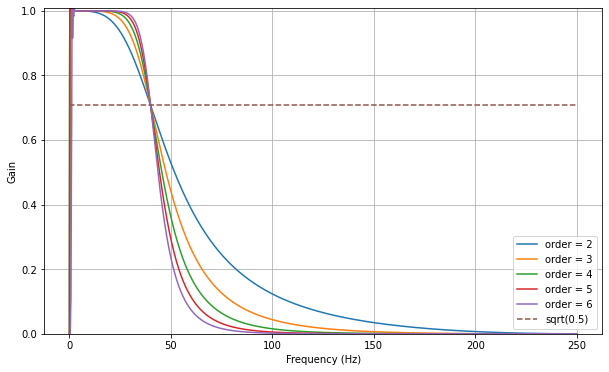

In [79]:
# Plot the frequency response for a few different orders.

def plot_freq_response():
    
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import freqz

    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 500.0
    lowcut = 0.1
    highcut = 40

    # Plot the frequency response for a few different orders.
    plt.figure(figsize=(10,6))
    plt.clf()
    for order in [2,3,4, 5, 6]:
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        w, h = freqz(b, a, worN=2000)
        plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

    plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.ylim(0, 1.01)
    plt.grid(True)
    plt.legend(loc='best')
    


### Data Visualisation

- calculate the sampling frequency
- Plot the EEG signal
- Visualise the sampling of the data


### a) Visualise the EEG signals

In [61]:
def plotEEG():
    import matplotlib.pyplot as plt
    df = get_training_file()
    channels = df.iloc[:, :8].columns
    subset = df[:100]
    print(len(channels))
    fig = plt.figure(figsize=(20,20))
    for i in range(len(channels)):
        ax = fig.add_subplot(4,2,i+1)
        ax.plot(subset['Timestamp'], subset[channels[i]])
        ax.set_title(channels[i])
        ax.set_xlabel("Timestamp")
    plt.show()




### b) Visualising the class distribution 

In [62]:
def viz_class_dist():
    sampled_file = "User_1_sampled_annotated_EEG.pickle"
    with open(sampled_file, 'rb') as handle:
        user_1_tests = pickle.load(handle)
    labels = ["attention", "effort", "interest"]

    fig, axes = plt.subplots(nrows=3, ncols=1 , figsize=(10,18))
    fig = plt.figure(figsize=(30,20))

    for i in range(3):
        ax = pd.Series(user_1_tests[labels[i]]).value_counts().plot(kind="barh" , title=labels[i] , ax=axes[i])
        ax.set_xlabel("frequency")
        ax.set_ylabel("Score")

    # df1.plot(ax=axes[0])
    # df2.plot(ax=axes[1])
    # df2.plot(ax=axes[1])

    #     fig = plt.figure()
    #     ax = fig.add_subplot(4,2,i+1)
    #     pd.Series(user_1_tests[label]).value_counts().plot(kind="barh" , title=label)
    #     ax.set_xlabel("frequency")
    #     ax.set_ylabel("Score")

    plt.show()